# Análisis Estadístico de Métricas XAI

Este notebook realiza un análisis estadístico riguroso de las métricas de explicabilidad obtenidas con Quantus.

**Objetivos:**
1. **Intervalos de Confianza del 95%**: Proporcionan una estimación del rango probable de los valores reales de las métricas.
2. **Tests de Significación Estadística**: Comparación por pares de métodos XAI usando el test de Wilcoxon (no paramétrico, adecuado para muestras pequeñas y distribuciones no normales).
3. **Análisis de Potencia Estadística**: Discusión sobre las limitaciones del tamaño muestral y su impacto en la capacidad de detectar diferencias significativas.

**Requisitos previos:**
- Ejecutar `quantus_evaluation.py` para los 3 datasets (blood, retina, breast) con `--num_samples 100`
- Los archivos JSON deben estar en `outputs/quantus_metrics_{dataset}.json`

**Nota**: Con 100 muestras por dataset, tenemos un tamaño muestral adecuado para análisis estadísticos básicos, aunque la potencia para detectar diferencias pequeñas puede ser limitada.

In [1]:
# Configuración inicial e importaciones

import os
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Definir ruta del proyecto (ajustar según tu sistema)
PROJECT_DIR = Path.cwd().resolve()  # Usa el directorio actual
# Alternativa para sistemas Linux: PROJECT_DIR = Path("/home/TFM_Laura_Monne").resolve()

# Configuración de rutas
OUTPUTS_DIR = PROJECT_DIR / "outputs"
OUTPUTS_DIR.mkdir(exist_ok=True)

# Lista de datasets
datasets = ["blood", "retina", "breast"]

# Métricas evaluadas
metric_names = ["faithfulness", "localization", "complexity", "randomization", "robustness"]
metric_labels = {
    "faithfulness": "Fidelidad",
    "localization": "Localización",
    "complexity": "Complejidad",
    "randomization": "Aleatorización",
    "robustness": "Robustez"
}

# Métodos XAI
methods = ["gradcam", "gradcampp", "integrated_gradients", "saliency"]
method_labels = {
    "gradcam": "Grad-CAM",
    "gradcampp": "Grad-CAM++",
    "integrated_gradients": "Integrated Gradients",
    "saliency": "Saliency Maps"
}

# Colores para visualización
method_colors = {
    "gradcam": "#1b9e77",   # teal
    "gradcampp": "#d95f02", # orange
    "integrated_gradients": "#1f77b4", # blue
    "saliency": "#d62728",  # red
}

print(f"✅ Configuración inicial completada")
print(f"📁 Directorio de outputs: {OUTPUTS_DIR}")

✅ Configuración inicial completada
📁 Directorio de outputs: /home/TFM_Laura_Monne/outputs


In [2]:
# Carga de resultados Quantus desde los archivos JSON

results_by_dataset = {}
metadata_rows = []

for dataset in datasets:
    json_path = OUTPUTS_DIR / f"quantus_metrics_{dataset}.json"
    if json_path.exists():
        with open(json_path, "r", encoding="utf-8") as f:
            results_by_dataset[dataset] = json.load(f)
        print(f"✅ Cargado: {dataset} ({json_path.name})")

        meta = results_by_dataset[dataset].get("metadata", {})
        metadata_rows.append({
            "Dataset": dataset.upper(),
            "Num samples": meta.get("num_samples"),
            "Sample strategy": meta.get("sample_strategy"),
            "Seed": meta.get("seed"),
            "Target": meta.get("target"),
            "Métodos": ", ".join(meta.get("methods", [])) if meta else None,
        })
    else:
        print(f"⚠️  No encontrado: {json_path.name}")
        print(f"   Ejecuta `python quantus_evaluation.py --dataset {dataset} --num_samples 100` antes de usar este notebook.")

if not results_by_dataset:
    raise ValueError("❌ No se encontraron resultados Quantus. Genera primero los ficheros JSON con quantus_evaluation.py.")

if metadata_rows:
    print("")
    print("Resumen de metadata:")
    display(pd.DataFrame(metadata_rows))

✅ Cargado: blood (quantus_metrics_blood.json)
✅ Cargado: retina (quantus_metrics_retina.json)
✅ Cargado: breast (quantus_metrics_breast.json)

Resumen de metadata:


,Dataset,Num samples,Sample strategy,Seed,Target,Métodos
0,BLOOD,100,reservoir,42,pred,"gradcam, gradcampp, integrated_gradients, sali..."
1,RETINA,100,reservoir,42,pred,"gradcam, gradcampp, integrated_gradients, sali..."
2,BREAST,100,reservoir,42,pred,"gradcam, gradcampp, integrated_gradients, sali..."


In [3]:
# Cargar datos individuales (scores por muestra) desde los JSON

def load_individual_scores(dataset_name: str) -> dict:
    """
    Carga los valores individuales (scores) por muestra para cada método y métrica.
    
    Returns:
        dict: {
            method: {
                metric: [score1, score2, ..., scoreN]  # Lista de valores por muestra
            }
        }
    """
    results = results_by_dataset[dataset_name]
    individual_data = {}
    
    for method in methods:
        if method not in results:
            continue
        individual_data[method] = {}
        for metric in metric_names:
            method_metric = results[method].get(metric, None)
            if method_metric is None:
                individual_data[method][metric] = None
            else:
                scores = method_metric.get("scores", [])
                # Filtrar None (valores inválidos) y convertir a numpy array
                valid_scores = [s for s in scores if s is not None]
                if len(valid_scores) == 0:
                    individual_data[method][metric] = None
                else:
                    individual_data[method][metric] = np.array(valid_scores, dtype=float)
    
    return individual_data

# Cargar datos individuales para todos los datasets
individual_scores_by_dataset = {}
for dataset in datasets:
    individual_scores_by_dataset[dataset] = load_individual_scores(dataset)
    print(f"✅ Datos individuales cargados para {dataset}")

print(f"\n📊 Número de muestras válidas por dataset:")
for dataset in datasets:
    for method in methods:
        if method in individual_scores_by_dataset[dataset]:
            for metric in metric_names:
                scores = individual_scores_by_dataset[dataset][method].get(metric)
                if scores is not None:
                    print(f"  {dataset}/{method}/{metric}: {len(scores)} muestras válidas")
                    break

✅ Datos individuales cargados para blood
✅ Datos individuales cargados para retina
✅ Datos individuales cargados para breast

📊 Número de muestras válidas por dataset:
  blood/gradcam/faithfulness: 100 muestras válidas
  blood/gradcampp/faithfulness: 100 muestras válidas
  blood/integrated_gradients/faithfulness: 100 muestras válidas
  blood/saliency/faithfulness: 100 muestras válidas
  retina/gradcam/faithfulness: 100 muestras válidas
  retina/gradcampp/faithfulness: 100 muestras válidas
  retina/integrated_gradients/faithfulness: 100 muestras válidas
  retina/saliency/faithfulness: 100 muestras válidas
  breast/gradcam/faithfulness: 100 muestras válidas
  breast/gradcampp/faithfulness: 100 muestras válidas
  breast/integrated_gradients/faithfulness: 100 muestras válidas
  breast/saliency/faithfulness: 100 muestras válidas


In [4]:
# Calcular Intervalos de Confianza del 95% (IC95%)

def calculate_confidence_interval(scores: np.ndarray, confidence: float = 0.95) -> tuple:
    """
    Calcula el intervalo de confianza usando la distribución t de Student.
    
    Args:
        scores: Array de valores
        confidence: Nivel de confianza (default: 0.95)
    
    Returns:
        (mean, lower_bound, upper_bound, sem)
    """
    if scores is None or len(scores) == 0:
        return (None, None, None, None)
    
    n = len(scores)
    mean = np.mean(scores)
    sem = stats.sem(scores)  # Error estándar de la media
    
    # Grados de libertad
    df = n - 1
    
    # Valor crítico t para IC95%
    t_critical = stats.t.ppf((1 + confidence) / 2, df)
    
    # Intervalo de confianza
    margin = t_critical * sem
    lower = mean - margin
    upper = mean + margin
    
    return (mean, lower, upper, sem)

# Calcular IC95% para todos los datasets, métodos y métricas
confidence_intervals = {}

for dataset in datasets:
    confidence_intervals[dataset] = {}
    for method in methods:
        if method not in individual_scores_by_dataset[dataset]:
            continue
        confidence_intervals[dataset][method] = {}
        for metric in metric_names:
            scores = individual_scores_by_dataset[dataset][method].get(metric)
            if scores is not None and len(scores) > 1:
                mean, lower, upper, sem = calculate_confidence_interval(scores)
                confidence_intervals[dataset][method][metric] = {
                    "mean": mean,
                    "lower_95": lower,
                    "upper_95": upper,
                    "sem": sem,
                    "n": len(scores)
                }
            else:
                confidence_intervals[dataset][method][metric] = None

print("✅ Intervalos de confianza calculados")

✅ Intervalos de confianza calculados


In [5]:
# Mostrar tablas de Intervalos de Confianza del 95%

def display_confidence_intervals_table(dataset_name: str, metric_name: str):
    """Muestra una tabla con IC95% para una métrica específica."""
    data_rows = []
    
    for method in methods:
        if method not in confidence_intervals[dataset_name]:
            continue
        ci_data = confidence_intervals[dataset_name][method].get(metric_name)
        if ci_data is not None:
            data_rows.append({
                "Método": method_labels.get(method, method),
                "Media": f"{ci_data['mean']:.4f}",
                "IC95% Inferior": f"{ci_data['lower_95']:.4f}",
                "IC95% Superior": f"{ci_data['upper_95']:.4f}",
                "SEM": f"{ci_data['sem']:.4f}",
                "N": ci_data['n']
            })
    
    if data_rows:
        df_ci = pd.DataFrame(data_rows)
        print(f"\n{'='*80}")
        print(f"Intervalos de Confianza del 95% - {dataset_name.upper()} - {metric_labels.get(metric_name, metric_name)}")
        print(f"{'='*80}")
        display(df_ci)
        return df_ci
    return None

# Mostrar IC95% para todas las métricas y datasets
for dataset in datasets:
    print(f"\n{'#'*80}")
    print(f"# INTERVALOS DE CONFIANZA DEL 95% - {dataset.upper()}")
    print(f"{'#'*80}")
    
    for metric in metric_names:
        display_confidence_intervals_table(dataset, metric)


################################################################################
# INTERVALOS DE CONFIANZA DEL 95% - BLOOD
################################################################################

Intervalos de Confianza del 95% - BLOOD - Fidelidad


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,-0.0365,-0.0801,0.0071,0.0220,100
1,Grad-CAM++,-0.0249,-0.0701,0.0202,0.0228,100
2,Integrated Gradients,0.0937,0.0528,0.1347,0.0206,100
3,Saliency Maps,0.0183,-0.0235,0.0602,0.0211,100



Intervalos de Confianza del 95% - BLOOD - Localización


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,0.1033,0.0950,0.1116,0.0042,3000
1,Grad-CAM++,0.1038,0.0955,0.1122,0.0043,3000
2,Integrated Gradients,0.3830,0.3672,0.3988,0.0081,3000
3,Saliency Maps,0.3128,0.2978,0.3277,0.0076,3000



Intervalos de Confianza del 95% - BLOOD - Complejidad


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,11.4850,11.4523,11.5178,0.0165,100
1,Grad-CAM++,11.5869,11.5688,11.6051,0.0092,100
2,Integrated Gradients,10.8481,10.8102,10.8860,0.0191,100
3,Saliency Maps,10.8532,10.8087,10.8978,0.0225,100



Intervalos de Confianza del 95% - BLOOD - Aleatorización


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,-0.1891,-0.2691,-0.1091,0.0400,60
1,Grad-CAM++,-0.3112,-0.3665,-0.2558,0.0279,100
2,Integrated Gradients,0.1152,0.1052,0.1251,0.0050,100
3,Saliency Maps,0.1694,0.1640,0.1747,0.0027,100



Intervalos de Confianza del 95% - BLOOD - Robustez


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,0.0098,0.0088,0.0107,0.0005,100
1,Grad-CAM++,0.0071,0.0066,0.0077,0.0003,100
2,Integrated Gradients,0.3005,0.2905,0.3105,0.0050,100
3,Saliency Maps,0.2685,0.2571,0.2799,0.0057,100



################################################################################
# INTERVALOS DE CONFIANZA DEL 95% - RETINA
################################################################################

Intervalos de Confianza del 95% - RETINA - Fidelidad


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,0.0444,0.0004,0.0884,0.0222,100
1,Grad-CAM++,0.0090,-0.0422,0.0603,0.0258,100
2,Integrated Gradients,0.0121,-0.0227,0.0468,0.0175,100
3,Saliency Maps,-0.0033,-0.0468,0.0401,0.0219,100



Intervalos de Confianza del 95% - RETINA - Localización


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,0.1413,0.1361,0.1466,0.0027,3000
1,Grad-CAM++,0.1252,0.1193,0.1310,0.0030,3000
2,Integrated Gradients,0.2107,0.2038,0.2175,0.0035,3000
3,Saliency Maps,0.1559,0.1498,0.1620,0.0031,3000



Intervalos de Confianza del 95% - RETINA - Complejidad


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,11.4975,11.4705,11.5246,0.0136,100
1,Grad-CAM++,11.5575,11.5406,11.5744,0.0085,100
2,Integrated Gradients,11.1852,11.1573,11.2131,0.0141,100
3,Saliency Maps,11.2193,11.2050,11.2336,0.0072,100



Intervalos de Confianza del 95% - RETINA - Aleatorización


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,-0.1132,-0.1645,-0.0618,0.0259,91
1,Grad-CAM++,-0.5964,-0.6396,-0.5533,0.0217,100
2,Integrated Gradients,0.2254,0.2089,0.2418,0.0083,100
3,Saliency Maps,0.1298,0.1269,0.1327,0.0015,100



Intervalos de Confianza del 95% - RETINA - Robustez


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,0.1300,0.1182,0.1418,0.0059,62
1,Grad-CAM++,0.0898,0.0777,0.1019,0.0060,60
2,Integrated Gradients,0.8870,0.8742,0.8998,0.0064,62
3,Saliency Maps,1.2511,1.1959,1.3062,0.0276,64



################################################################################
# INTERVALOS DE CONFIANZA DEL 95% - BREAST
################################################################################

Intervalos de Confianza del 95% - BREAST - Fidelidad


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,0.1050,0.0590,0.1509,0.0232,100
1,Grad-CAM++,0.0692,0.0278,0.1107,0.0209,100
2,Integrated Gradients,0.0000,-0.0347,0.0348,0.0175,100
3,Saliency Maps,0.0803,0.0445,0.1160,0.0180,100



Intervalos de Confianza del 95% - BREAST - Localización


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,0.1162,0.0997,0.1327,0.0084,3000
1,Grad-CAM++,0.1177,0.1012,0.1343,0.0084,3000
2,Integrated Gradients,0.1215,0.1046,0.1384,0.0086,3000
3,Saliency Maps,0.1213,0.1045,0.1382,0.0086,3000



Intervalos de Confianza del 95% - BREAST - Complejidad


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,11.1104,11.0527,11.1681,0.0291,100
1,Grad-CAM++,11.3377,11.2960,11.3795,0.0211,100
2,Integrated Gradients,10.8763,10.8301,10.9225,0.0233,100
3,Saliency Maps,11.0074,10.9702,11.0445,0.0187,100



Intervalos de Confianza del 95% - BREAST - Aleatorización


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,-0.3215,-0.3661,-0.2769,0.0224,72
1,Grad-CAM++,-0.0241,-0.1009,0.0527,0.0387,100
2,Integrated Gradients,0.3131,0.3016,0.3246,0.0058,100
3,Saliency Maps,0.0919,0.0844,0.0993,0.0038,100



Intervalos de Confianza del 95% - BREAST - Robustez


,Método,Media,IC95% Inferior,IC95% Superior,SEM,N
0,Grad-CAM,0.2837,0.2384,0.3291,0.0228,82
1,Grad-CAM++,0.2113,0.1811,0.2415,0.0152,82
2,Integrated Gradients,0.8979,0.8936,0.9022,0.0022,81
3,Saliency Maps,1.0326,1.0025,1.0627,0.0151,81


In [6]:
# Tests de Significación Estadística: Test de Wilcoxon (comparación por pares)

def perform_wilcoxon_tests(dataset_name: str, metric_name: str, alpha: float = 0.05) -> pd.DataFrame:
    """
    Realiza tests de Wilcoxon (signed-rank test) para comparar métodos XAI por pares.
    
    El test de Wilcoxon es no paramétrico y adecuado para:
    - Muestras pequeñas (n < 30)
    - Distribuciones no normales
    - Datos pareados
    
    Args:
        dataset_name: Nombre del dataset
        metric_name: Nombre de la métrica
        alpha: Nivel de significación (default: 0.05)
    
    Returns:
        DataFrame con resultados de los tests
    """
    # Obtener métodos disponibles
    available_methods = [m for m in methods if m in individual_scores_by_dataset[dataset_name]]
    available_methods = [m for m in available_methods 
                        if individual_scores_by_dataset[dataset_name][m].get(metric_name) is not None]
    
    if len(available_methods) < 2:
        return None
    
    # Realizar comparaciones por pares
    test_results = []
    
    for i, method1 in enumerate(available_methods):
        scores1 = individual_scores_by_dataset[dataset_name][method1].get(metric_name)
        if scores1 is None or len(scores1) == 0:
            continue
            
        for method2 in available_methods[i+1:]:
            scores2 = individual_scores_by_dataset[dataset_name][method2].get(metric_name)
            if scores2 is None or len(scores2) == 0:
                continue
            
            # Asegurar que tienen la misma longitud (tomar el mínimo)
            min_len = min(len(scores1), len(scores2))
            s1 = scores1[:min_len]
            s2 = scores2[:min_len]
            
            # Test de Wilcoxon (signed-rank test)
            try:
                statistic, p_value = wilcoxon(s1, s2, alternative='two-sided')
                
                # Determinar significación
                is_significant = p_value < alpha
                
                # Calcular diferencia de medias
                mean_diff = np.mean(s1) - np.mean(s2)
                
                test_results.append({
                    "Método 1": method_labels.get(method1, method1),
                    "Método 2": method_labels.get(method2, method2),
                    "Media 1": f"{np.mean(s1):.4f}",
                    "Media 2": f"{np.mean(s2):.4f}",
                    "Diferencia": f"{mean_diff:.4f}",
                    "Estadístico W": f"{statistic:.2f}",
                    "p-valor": f"{p_value:.4f}",
                    f"Significativo (α={alpha})": "Sí" if is_significant else "No"
                })
            except Exception as e:
                # Si hay un error (p. ej., todas las diferencias son cero)
                test_results.append({
                    "Método 1": method_labels.get(method1, method1),
                    "Método 2": method_labels.get(method2, method2),
                    "Media 1": f"{np.mean(s1):.4f}",
                    "Media 2": f"{np.mean(s2):.4f}",
                    "Diferencia": f"{np.mean(s1) - np.mean(s2):.4f}",
                    "Estadístico W": "N/A",
                    "p-valor": "N/A",
                    f"Significativo (α={alpha})": "Error"
                })
    
    if test_results:
        df_tests = pd.DataFrame(test_results)
        return df_tests
    return None

# Realizar tests de Wilcoxon para todas las métricas y datasets
wilcoxon_results = {}

for dataset in datasets:
    wilcoxon_results[dataset] = {}
    print(f"\n{'#'*80}")
    print(f"# TESTS DE WILCOXON - {dataset.upper()}")
    print(f"{'#'*80}")
    
    for metric in metric_names:
        df_tests = perform_wilcoxon_tests(dataset, metric)
        if df_tests is not None and len(df_tests) > 0:
            wilcoxon_results[dataset][metric] = df_tests
            print(f"\n{metric_labels.get(metric, metric).upper()}:")
            display(df_tests)
        else:
            print(f"\n{metric_labels.get(metric, metric).upper()}: No hay datos suficientes para realizar tests")
            wilcoxon_results[dataset][metric] = None


################################################################################
# TESTS DE WILCOXON - BLOOD
################################################################################

FIDELIDAD:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,-0.0365,-0.0249,-0.0116,2291.00,0.4211,No
1,Grad-CAM,Integrated Gradients,-0.0365,0.0937,-0.1303,1394.00,0.0001,Sí
2,Grad-CAM,Saliency Maps,-0.0365,0.0183,-0.0548,1924.00,0.0388,Sí
3,Grad-CAM++,Integrated Gradients,-0.0249,0.0937,-0.1187,1475.00,0.0003,Sí
4,Grad-CAM++,Saliency Maps,-0.0249,0.0183,-0.0432,2049.00,0.1017,No
5,Integrated Gradients,Saliency Maps,0.0937,0.0183,0.0754,1775.00,0.0099,Sí



LOCALIZACIÓN:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,0.1033,0.1038,-0.0006,1245633.00,0.0102,Sí
1,Grad-CAM,Integrated Gradients,0.1033,0.3830,-0.2798,324870.50,0.0000,Sí
2,Grad-CAM,Saliency Maps,0.1033,0.3128,-0.2095,532888.50,0.0000,Sí
3,Grad-CAM++,Integrated Gradients,0.1038,0.3830,-0.2792,315573.00,0.0000,Sí
4,Grad-CAM++,Saliency Maps,0.1038,0.3128,-0.2089,494005.50,0.0000,Sí
5,Integrated Gradients,Saliency Maps,0.3830,0.3128,0.0703,1269200.50,0.0000,Sí



COMPLEJIDAD:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,11.4850,11.5869,-0.1019,313.00,0.0000,Sí
1,Grad-CAM,Integrated Gradients,11.4850,10.8481,0.6369,0.00,0.0000,Sí
2,Grad-CAM,Saliency Maps,11.4850,10.8532,0.6318,0.00,0.0000,Sí
3,Grad-CAM++,Integrated Gradients,11.5869,10.8481,0.7388,0.00,0.0000,Sí
4,Grad-CAM++,Saliency Maps,11.5869,10.8532,0.7337,0.00,0.0000,Sí
5,Integrated Gradients,Saliency Maps,10.8481,10.8532,-0.0051,2185.00,0.2424,No



ALEATORIZACIÓN:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,-0.1891,-0.3304,0.1413,551.00,0.0074,Sí
1,Grad-CAM,Integrated Gradients,-0.1891,0.1165,-0.3056,126.00,0.0000,Sí
2,Grad-CAM,Saliency Maps,-0.1891,0.1672,-0.3563,73.00,0.0000,Sí
3,Grad-CAM++,Integrated Gradients,-0.3112,0.1152,-0.4263,121.00,0.0000,Sí
4,Grad-CAM++,Saliency Maps,-0.3112,0.1694,-0.4805,85.00,0.0000,Sí
5,Integrated Gradients,Saliency Maps,0.1152,0.1694,-0.0542,314.00,0.0000,Sí



ROBUSTEZ:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,0.0098,0.0071,0.0026,126.00,0.0000,Sí
1,Grad-CAM,Integrated Gradients,0.0098,0.3005,-0.2908,0.00,0.0000,Sí
2,Grad-CAM,Saliency Maps,0.0098,0.2685,-0.2588,0.00,0.0000,Sí
3,Grad-CAM++,Integrated Gradients,0.0071,0.3005,-0.2934,0.00,0.0000,Sí
4,Grad-CAM++,Saliency Maps,0.0071,0.2685,-0.2614,0.00,0.0000,Sí
5,Integrated Gradients,Saliency Maps,0.3005,0.2685,0.0320,671.00,0.0000,Sí



################################################################################
# TESTS DE WILCOXON - RETINA
################################################################################

FIDELIDAD:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,0.0444,0.0090,0.0353,2186.00,0.2438,No
1,Grad-CAM,Integrated Gradients,0.0444,0.0121,0.0323,2093.00,0.1374,No
2,Grad-CAM,Saliency Maps,0.0444,-0.0033,0.0477,1975.00,0.0586,No
3,Grad-CAM++,Integrated Gradients,0.0090,0.0121,-0.0031,2453.00,0.8045,No
4,Grad-CAM++,Saliency Maps,0.0090,-0.0033,0.0124,2285.00,0.4093,No
5,Integrated Gradients,Saliency Maps,0.0121,-0.0033,0.0154,2469.00,0.8473,No



LOCALIZACIÓN:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,0.1413,0.1252,0.0162,1660982.00,0.0000,Sí
1,Grad-CAM,Integrated Gradients,0.1413,0.2107,-0.0693,1112221.00,0.0000,Sí
2,Grad-CAM,Saliency Maps,0.1413,0.1559,-0.0146,1938138.00,0.0000,Sí
3,Grad-CAM++,Integrated Gradients,0.1252,0.2107,-0.0855,937166.00,0.0000,Sí
4,Grad-CAM++,Saliency Maps,0.1252,0.1559,-0.0308,1583546.00,0.0000,Sí
5,Integrated Gradients,Saliency Maps,0.2107,0.1559,0.0547,1099724.00,0.0000,Sí



COMPLEJIDAD:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,11.4975,11.5575,-0.0600,1093.00,0.0000,Sí
1,Grad-CAM,Integrated Gradients,11.4975,11.1852,0.3123,26.00,0.0000,Sí
2,Grad-CAM,Saliency Maps,11.4975,11.2193,0.2782,10.00,0.0000,Sí
3,Grad-CAM++,Integrated Gradients,11.5575,11.1852,0.3723,0.00,0.0000,Sí
4,Grad-CAM++,Saliency Maps,11.5575,11.2193,0.3382,0.00,0.0000,Sí
5,Integrated Gradients,Saliency Maps,11.1852,11.2193,-0.0341,2175.00,0.2288,No



ALEATORIZACIÓN:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,-0.1132,-0.5901,0.4770,117.00,0.0000,Sí
1,Grad-CAM,Integrated Gradients,-0.1132,0.2242,-0.3373,185.00,0.0000,Sí
2,Grad-CAM,Saliency Maps,-0.1132,0.1293,-0.2424,387.00,0.0000,Sí
3,Grad-CAM++,Integrated Gradients,-0.5964,0.2254,-0.8218,0.00,0.0000,Sí
4,Grad-CAM++,Saliency Maps,-0.5964,0.1298,-0.7262,2.00,0.0000,Sí
5,Integrated Gradients,Saliency Maps,0.2254,0.1298,0.0956,94.00,0.0000,Sí



ROBUSTEZ:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,0.1303,0.0898,0.0405,223.00,0.0000,Sí
1,Grad-CAM,Integrated Gradients,0.1300,0.8870,-0.7569,0.00,0.0000,Sí
2,Grad-CAM,Saliency Maps,0.1300,1.2587,-1.1286,0.00,0.0000,Sí
3,Grad-CAM++,Integrated Gradients,0.0898,0.8886,-0.7988,0.00,0.0000,Sí
4,Grad-CAM++,Saliency Maps,0.0898,1.2677,-1.1779,0.00,0.0000,Sí
5,Integrated Gradients,Saliency Maps,0.8870,1.2587,-0.3717,3.00,0.0000,Sí



################################################################################
# TESTS DE WILCOXON - BREAST
################################################################################

FIDELIDAD:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,0.1050,0.0692,0.0357,2064.00,0.1130,No
1,Grad-CAM,Integrated Gradients,0.1050,0.0000,0.1049,1525.00,0.0006,Sí
2,Grad-CAM,Saliency Maps,0.1050,0.0803,0.0247,2230.00,0.3104,No
3,Grad-CAM++,Integrated Gradients,0.0692,0.0000,0.0692,1905.00,0.0330,Sí
4,Grad-CAM++,Saliency Maps,0.0692,0.0803,-0.0111,2337.00,0.5180,No
5,Integrated Gradients,Saliency Maps,0.0000,0.0803,-0.0802,1660.00,0.0029,Sí



LOCALIZACIÓN:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,0.1162,0.1177,-0.0015,1801013.00,0.0382,Sí
1,Grad-CAM,Integrated Gradients,0.1162,0.1215,-0.0053,2033640.50,0.0000,Sí
2,Grad-CAM,Saliency Maps,0.1162,0.1213,-0.0051,2196993.50,0.3767,No
3,Grad-CAM++,Integrated Gradients,0.1177,0.1215,-0.0038,1947211.50,0.0000,Sí
4,Grad-CAM++,Saliency Maps,0.1177,0.1213,-0.0036,2134429.50,0.0343,Sí
5,Integrated Gradients,Saliency Maps,0.1215,0.1213,0.0002,948028.00,0.0000,Sí



COMPLEJIDAD:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,11.1104,11.3377,-0.2273,511.00,0.0000,Sí
1,Grad-CAM,Integrated Gradients,11.1104,10.8763,0.2341,906.00,0.0000,Sí
2,Grad-CAM,Saliency Maps,11.1104,11.0074,0.1030,1502.00,0.0004,Sí
3,Grad-CAM++,Integrated Gradients,11.3377,10.8763,0.4614,0.00,0.0000,Sí
4,Grad-CAM++,Saliency Maps,11.3377,11.0074,0.3304,27.00,0.0000,Sí
5,Integrated Gradients,Saliency Maps,10.8763,11.0074,-0.1311,568.00,0.0000,Sí



ALEATORIZACIÓN:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,-0.3215,-0.0275,-0.2940,409.00,0.0000,Sí
1,Grad-CAM,Integrated Gradients,-0.3215,0.3192,-0.6407,0.00,0.0000,Sí
2,Grad-CAM,Saliency Maps,-0.3215,0.0899,-0.4114,8.00,0.0000,Sí
3,Grad-CAM++,Integrated Gradients,-0.0241,0.3131,-0.3372,472.00,0.0000,Sí
4,Grad-CAM++,Saliency Maps,-0.0241,0.0919,-0.1160,1787.00,0.0112,Sí
5,Integrated Gradients,Saliency Maps,0.3131,0.0919,0.2212,2.00,0.0000,Sí



ROBUSTEZ:


,Método 1,Método 2,Media 1,Media 2,Diferencia,Estadístico W,p-valor,Significativo (α=0.05)
0,Grad-CAM,Grad-CAM++,0.2837,0.2113,0.0724,975.00,0.0008,Sí
1,Grad-CAM,Integrated Gradients,0.2862,0.8979,-0.6117,0.00,0.0000,Sí
2,Grad-CAM,Saliency Maps,0.2862,1.0326,-0.7464,0.00,0.0000,Sí
3,Grad-CAM++,Integrated Gradients,0.2127,0.8979,-0.6852,0.00,0.0000,Sí
4,Grad-CAM++,Saliency Maps,0.2127,1.0326,-0.8199,0.00,0.0000,Sí
5,Integrated Gradients,Saliency Maps,0.8979,1.0326,-0.1347,16.00,0.0000,Sí


In [7]:
# Guardar resultados estadísticos en archivos CSV

print("=== Guardando resultados estadísticos en outputs/ ===\n")

# Guardar intervalos de confianza
for dataset in datasets:
    ci_rows = []
    for method in methods:
        if method not in confidence_intervals[dataset]:
            continue
        for metric in metric_names:
            ci_data = confidence_intervals[dataset][method].get(metric)
            if ci_data is not None:
                ci_rows.append({
                    "Dataset": dataset,
                    "Método": method,
                    "Métrica": metric,
                    "Media": ci_data['mean'],
                    "IC95_Lower": ci_data['lower_95'],
                    "IC95_Upper": ci_data['upper_95'],
                    "SEM": ci_data['sem'],
                    "N": ci_data['n']
                })
    
    if ci_rows:
        df_ci_all = pd.DataFrame(ci_rows)
        ci_path = OUTPUTS_DIR / f"quantus_confidence_intervals_{dataset}.csv"
        df_ci_all.to_csv(ci_path, index=False)
        print(f"📁 Guardado: {ci_path.name}")

# Guardar tests de Wilcoxon
for dataset in datasets:
    for metric in metric_names:
        if metric in wilcoxon_results[dataset] and wilcoxon_results[dataset][metric] is not None:
            df_wilcoxon = wilcoxon_results[dataset][metric]
            wilcoxon_path = OUTPUTS_DIR / f"quantus_wilcoxon_{dataset}_{metric}.csv"
            df_wilcoxon.to_csv(wilcoxon_path, index=False)
            print(f"📁 Guardado: {wilcoxon_path.name}")

print("\n✅ Resultados estadísticos guardados")

=== Guardando resultados estadísticos en outputs/ ===

📁 Guardado: quantus_confidence_intervals_blood.csv
📁 Guardado: quantus_confidence_intervals_retina.csv
📁 Guardado: quantus_confidence_intervals_breast.csv
📁 Guardado: quantus_wilcoxon_blood_faithfulness.csv
📁 Guardado: quantus_wilcoxon_blood_localization.csv
📁 Guardado: quantus_wilcoxon_blood_complexity.csv
📁 Guardado: quantus_wilcoxon_blood_randomization.csv
📁 Guardado: quantus_wilcoxon_blood_robustness.csv
📁 Guardado: quantus_wilcoxon_retina_faithfulness.csv
📁 Guardado: quantus_wilcoxon_retina_localization.csv
📁 Guardado: quantus_wilcoxon_retina_complexity.csv
📁 Guardado: quantus_wilcoxon_retina_randomization.csv
📁 Guardado: quantus_wilcoxon_retina_robustness.csv
📁 Guardado: quantus_wilcoxon_breast_faithfulness.csv
📁 Guardado: quantus_wilcoxon_breast_localization.csv
📁 Guardado: quantus_wilcoxon_breast_complexity.csv
📁 Guardado: quantus_wilcoxon_breast_randomization.csv
📁 Guardado: quantus_wilcoxon_breast_robustness.csv

✅ Result

Generando gráficos de Intervalos de Confianza...

✅ Figura guardada: quantus_ci_blood_faithfulness.png


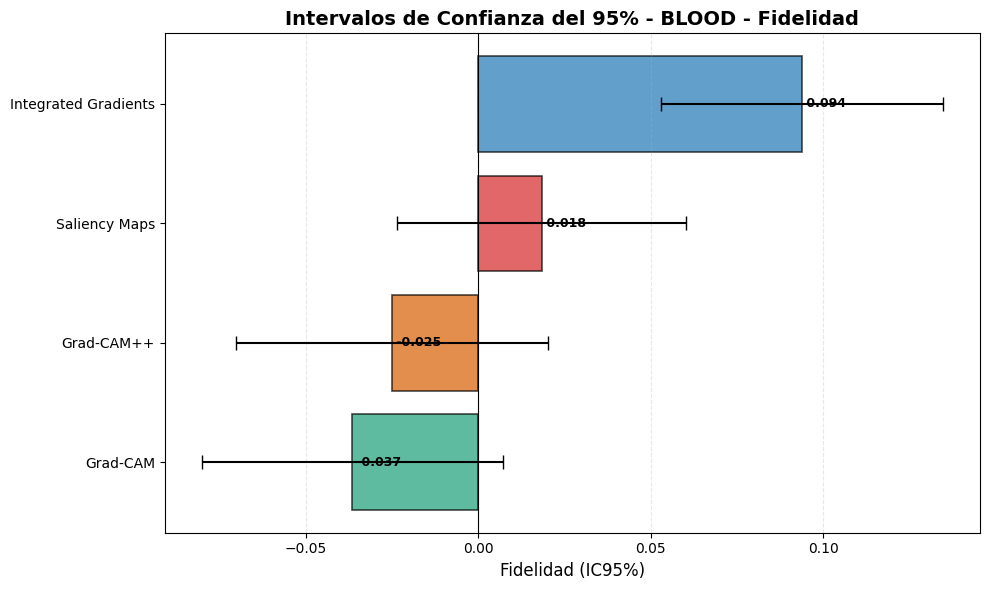

✅ Figura guardada: quantus_ci_blood_robustness.png


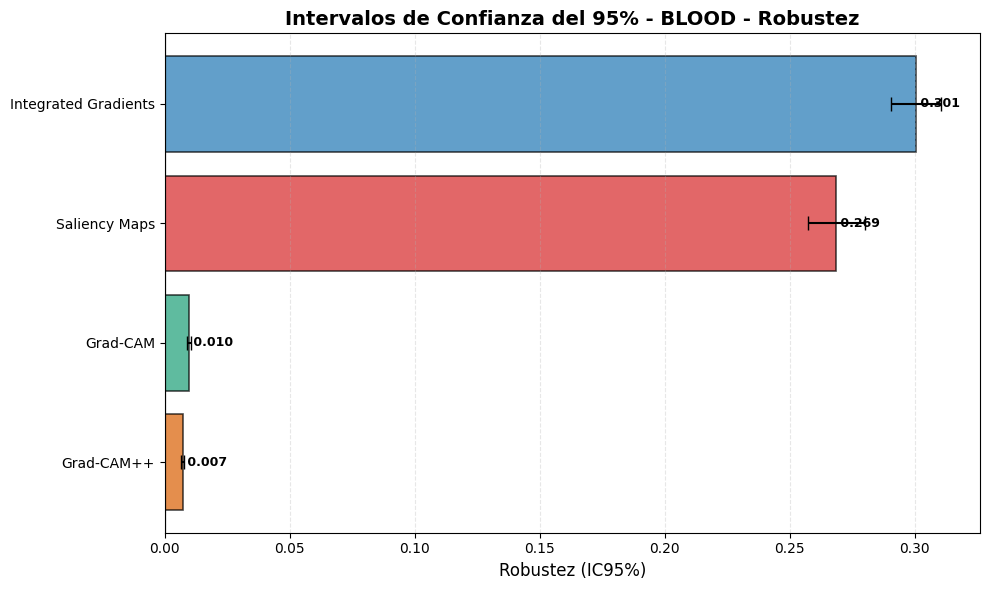

✅ Figura guardada: quantus_ci_blood_localization.png


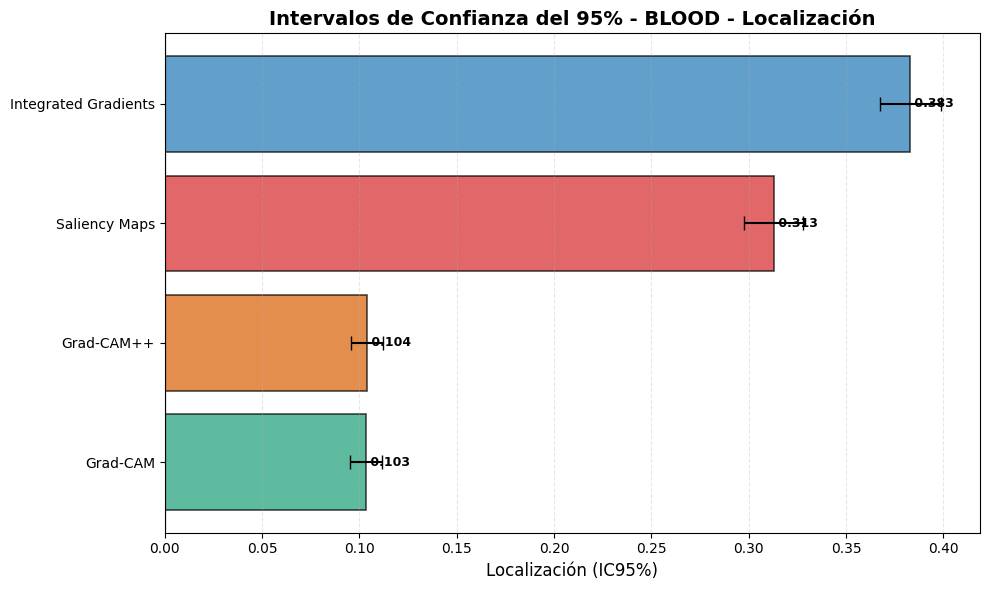

✅ Figura guardada: quantus_ci_retina_faithfulness.png


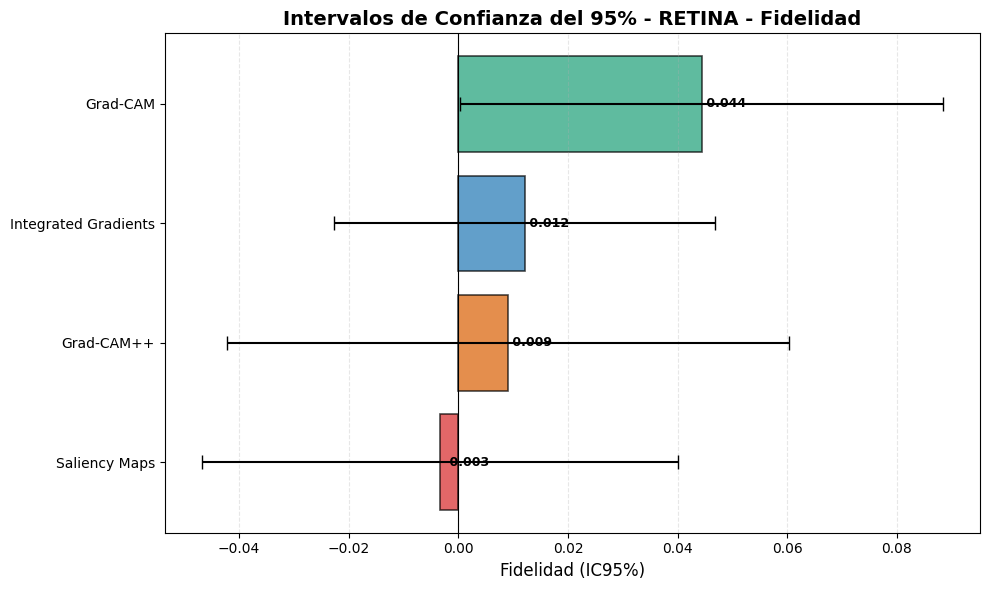

✅ Figura guardada: quantus_ci_retina_robustness.png


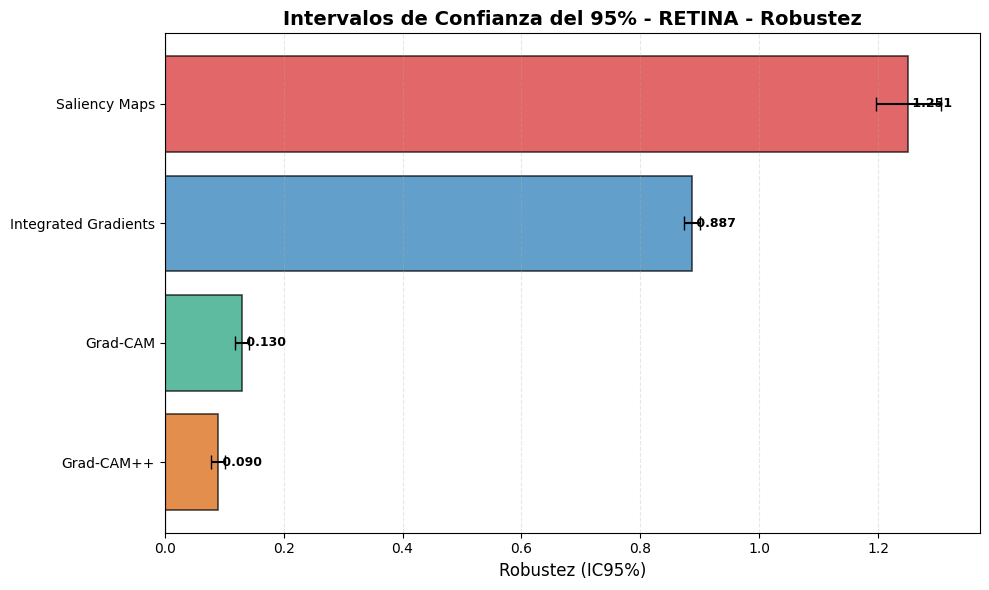

✅ Figura guardada: quantus_ci_retina_localization.png


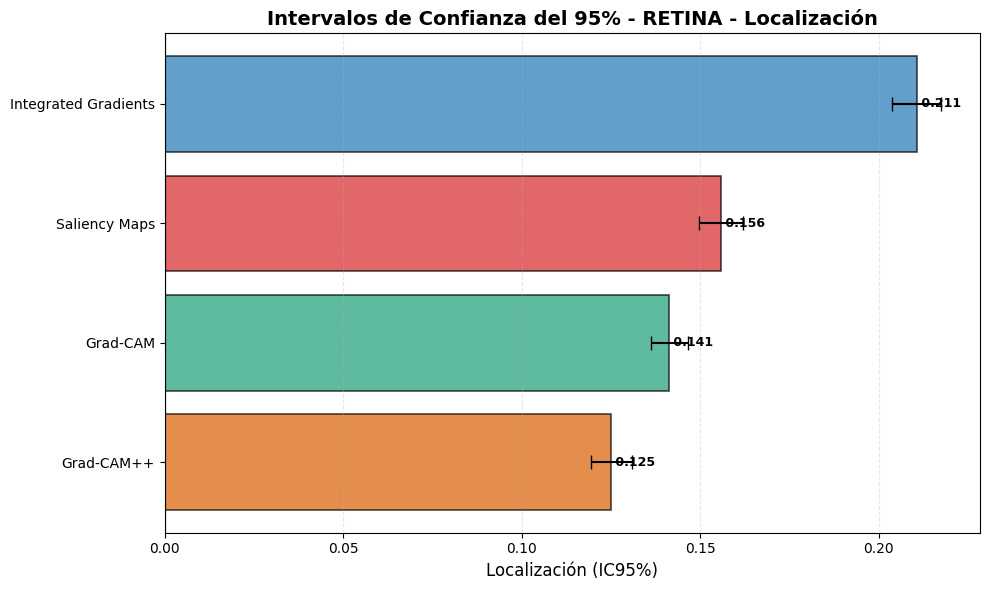

✅ Figura guardada: quantus_ci_breast_faithfulness.png


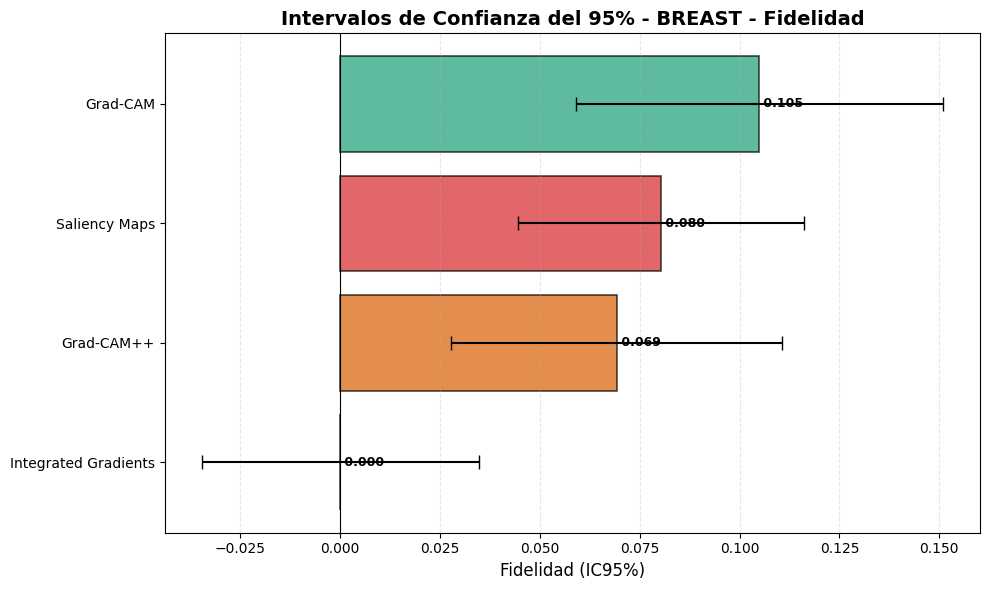

✅ Figura guardada: quantus_ci_breast_robustness.png


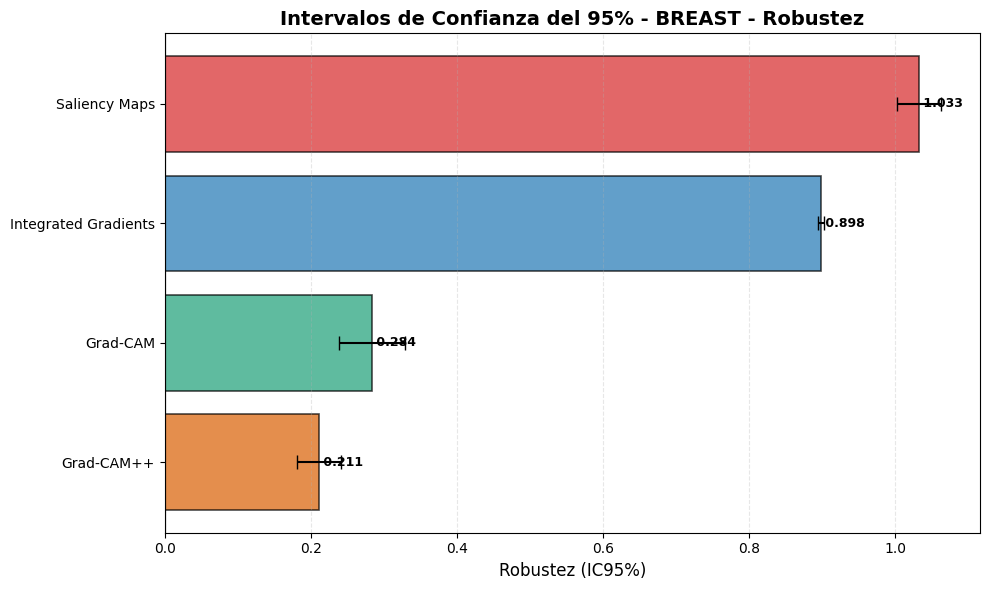

✅ Figura guardada: quantus_ci_breast_localization.png


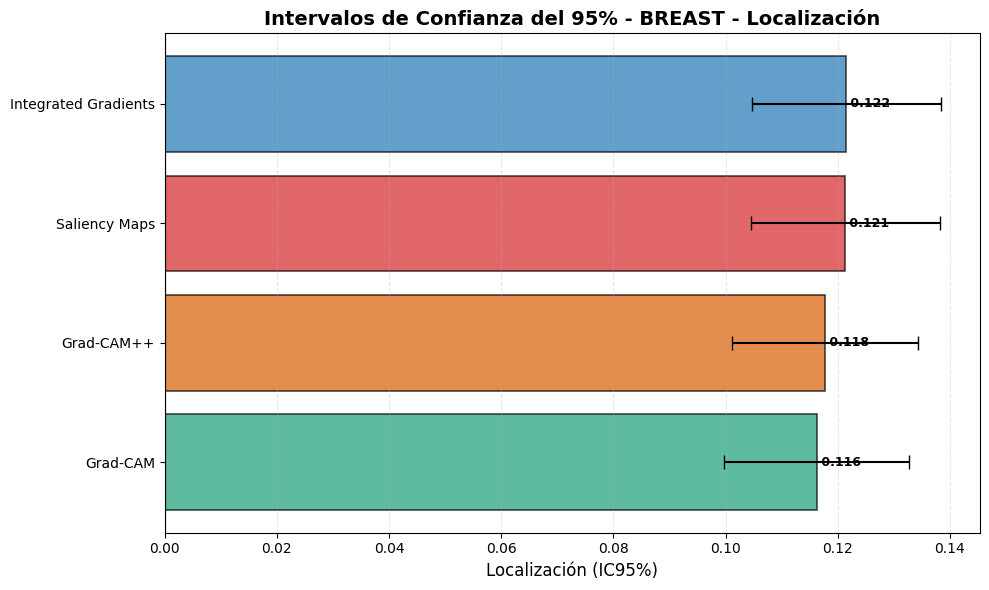

In [8]:
# Visualización: Intervalos de Confianza del 95% por Método y Métrica

def plot_confidence_intervals(dataset_name: str, metric_name: str, figsize=(10, 6)):
    """Genera un gráfico de barras con intervalos de confianza del 95%."""
    data_rows = []
    
    for method in methods:
        if method not in confidence_intervals[dataset_name]:
            continue
        ci_data = confidence_intervals[dataset_name][method].get(metric_name)
        if ci_data is not None:
            data_rows.append({
                "method": method,
                "mean": ci_data['mean'],
                "lower": ci_data['lower_95'],
                "upper": ci_data['upper_95'],
                "sem": ci_data['sem']
            })
    
    if not data_rows:
        print(f"No hay datos para {dataset_name} - {metric_name}")
        return
    
    df_plot = pd.DataFrame(data_rows)
    df_plot = df_plot.sort_values('mean', ascending=True)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    x_pos = np.arange(len(df_plot))
    means = df_plot['mean'].values
    lowers = df_plot['lower'].values
    uppers = df_plot['upper'].values
    
    # Barras de error
    errors = [means - lowers, uppers - means]
    
    bars = ax.barh(x_pos, means, xerr=errors, capsize=5, 
                   color=[method_colors.get(m, 'gray') for m in df_plot['method'].values],
                   alpha=0.7, edgecolor='black', linewidth=1.2)
    
    ax.set_yticks(x_pos)
    ax.set_yticklabels([method_labels.get(m, m) for m in df_plot['method'].values])
    ax.set_xlabel(f'{metric_labels.get(metric_name, metric_name)} (IC95%)', fontsize=12)
    ax.set_title(f'Intervalos de Confianza del 95% - {dataset_name.upper()} - {metric_labels.get(metric_name, metric_name)}', 
                 fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.axvline(x=0, color='black', linewidth=0.8, linestyle='-')
    
    # Añadir valores en las barras
    for i, (mean, lower, upper) in enumerate(zip(means, lowers, uppers)):
        ax.text(mean, i, f' {mean:.3f}', va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    # Guardar figura
    out_path = OUTPUTS_DIR / f"quantus_ci_{dataset_name}_{metric_name}.png"
    fig.savefig(out_path, dpi=300, facecolor='white', bbox_inches='tight')
    print(f"✅ Figura guardada: {out_path.name}")
    
    plt.show()
    plt.close()

# Generar gráficos de IC95% para métricas clave
print("Generando gráficos de Intervalos de Confianza...\n")

key_metrics = ["faithfulness", "robustness", "localization"]  # Métricas más importantes

for dataset in datasets:
    for metric in key_metrics:
        if metric in metric_names:
            plot_confidence_intervals(dataset, metric)

## Discusión: Limitaciones de Potencia Estadística

### Tamaño Muestral y Potencia

**Tamaño muestral actual**: 100 muestras por dataset

**Consideraciones**:

1. **Potencia Estadística Limitada para Diferencias Pequeñas**:
   - Con n=100, la potencia para detectar diferencias pequeñas (efectos pequeños, d < 0.3) es limitada.
   - Para detectar diferencias pequeñas con potencia del 80% (α=0.05), se necesitarían aproximadamente 200-300 muestras.
   - Las diferencias grandes (efectos grandes, d > 0.8) son detectables con n=100.

2. **Tests No Paramétricos (Wilcoxon)**:
   - El test de Wilcoxon es menos potente que tests paramétricos (t-test) cuando los datos son normales.
   - Sin embargo, es más robusto ante violaciones de normalidad y adecuado para muestras pequeñas.
   - Con n=100, el test de Wilcoxon tiene buena potencia para diferencias medianas-grandes.

3. **Corrección por Múltiples Comparaciones**:
   - Se realizan múltiples tests (4 métodos → 6 comparaciones por métrica).
   - Sin corrección (Bonferroni, FDR), aumenta el riesgo de falsos positivos (Type I error).
   - **Recomendación**: Considerar corrección de Bonferroni para análisis más conservadores:
     - α_ajustado = α / número_de_comparaciones
     - Para 6 comparaciones: α_ajustado = 0.05 / 6 ≈ 0.0083

4. **Intervalos de Confianza del 95%**:
   - Los IC95% proporcionan una estimación del rango probable de los valores reales.
   - Con n=100, los IC95% son razonablemente precisos (SEM ≈ σ/√100).
   - Si los IC95% de dos métodos no se solapan, sugiere una diferencia significativa.

### Recomendaciones para Futuros Estudios

1. **Aumentar tamaño muestral a 200-300 muestras** para mejorar la potencia estadística.
2. **Aplicar corrección de Bonferroni o FDR** para controlar el error de tipo I en múltiples comparaciones.
3. **Realizar análisis de potencia a priori** para determinar el tamaño muestral necesario según el tamaño del efecto esperado.
4. **Considerar análisis bayesiano** como alternativa complementaria para comparaciones de métodos.

### Interpretación de Resultados

- **p-valor < 0.05**: Evidencia estadística de diferencia (sin corrección por múltiples comparaciones).
- **IC95% no solapados**: Sugiere diferencia significativa entre métodos.
- **Diferencia de medias pequeña pero significativa**: Puede no ser clínicamente relevante; considerar tamaño del efecto (Cohen's d).
